## Phase 1: Focal Loss Strategy to Address Class Imbalance

## Problem Statement
- Current 3-class model achieves only **35.56% accuracy** (barely better than random 33.3%)
- Root cause: **Class imbalance and signal-to-noise ratio near zero in neutral zone**
  - Down: 31.65%, Neutral: 33.57% (majority), Up: 35.01%
  - Model defaults to predicting Neutral (38.8%) while under-predicting Down (22.4%)

## Solution: Focal Loss
**Academic Reference**: Lin et al., "Focal Loss for Dense Object Detection" (2017)

Focal Loss addresses imbalanced classification by:
1. Down-weighting loss from easy examples (well-classified samples)
2. Focusing training on hard examples (misclassified samples)
3. Reducing contribution of majority class to overall loss

**Mathematical Form**:
$$FL(p_t) = -\alpha_t (1 - p_t)^{\gamma} \log(p_t)$$

Where:
- $p_t$ = probability of true class
- $\alpha$ = class weight (penalize majority)
- $\gamma$ = focusing parameter (typically 2.0)

## Expected Outcome
- **Baseline**: 35.56% accuracy with CrossEntropyLoss
- **Target**: 45-50% accuracy with Focal Loss
- **Decision**: If successful → continue to Phase 2 (Multi-task learning)
                 If plateaus → investigate features or temporal design

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tools.SP100Stock import SP100Stocks
from models import TGCN, train, measure_accuracy, get_confusion_matrix

/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def future_close_price_to_buy_sell_class(sample: Data, threshold: float = 0.01):
	"""
	Transforms the target y to a three-class classification:
	- Down (0): return < -threshold
	- Neutral (1): -threshold <= return <= threshold
	- Up (2): return > threshold
	:param sample: Data sample
	:param threshold: Threshold for categorizing returns (default: 0.01 = 1%)
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	
	# Create three-class labels: 0=Down, 1=Neutral, 2=Up
	sample.y = torch.zeros_like(sample.returns, dtype=torch.long).squeeze(1)
	sample.y[sample.returns.squeeze(1) < -threshold] = 0  # Down
	sample.y[(sample.returns.squeeze(1) >= -threshold) & (sample.returns.squeeze(1) <= threshold)] = 1  # Neutral
	sample.y[sample.returns.squeeze(1) > threshold] = 2  # Up
	
	return sample

In [3]:
from functools import partial

weeks_ahead = 1
threshold = 0.0055  # 1% threshold for neutral zone

# Create a partial function with the threshold parameter
transform_with_threshold = partial(future_close_price_to_buy_sell_class, threshold=threshold)

dataset = SP100Stocks(root="data/", adj_file_name='hybrid_adj.npy', future_window=weeks_ahead, force_reload=True, transform=transform_with_threshold)
dataset, dataset[0]

Processing...


Loading and processing data for PyG format...
Values DataFrame shape: (70300, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 720
Unique symbols count: 100
Unique dates count: 703

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']
Pivoted shape (Date x Symbol): (703, 100)

Final array shapes:
  x (features): (100, 703, 13)
  close_prices: (100, 703)
  Expected x shape: (nodes_nb=100, timestamps_nb=703, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 703])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=703)

Building edge index and edge weights...
  Created 720 edges



Done!


(SP100Stocks(677),
 Data(x=[100, 13, 25], edge_index=[2, 720], y=[100], edge_weight=[720], close_price=[100, 25], close_price_y=[100, 1], returns=[100, 1], market_return=0.01731380820274353))

In [4]:
for i in range(0, 10):
	label = int(dataset[i].y[i].item())
	label_name = ['Down', 'Neutral', 'Up'][label]
	print(f"Stock return: {dataset[i].returns[i].item() * 100:.2f}%, trend: {label_name} (class {label})")

Stock return: 4.69%, trend: Up (class 2)
Stock return: -0.39%, trend: Neutral (class 1)
Stock return: -0.59%, trend: Down (class 0)
Stock return: 2.05%, trend: Up (class 2)
Stock return: -0.71%, trend: Down (class 0)
Stock return: -0.61%, trend: Down (class 0)
Stock return: 2.25%, trend: Up (class 2)
Stock return: -2.42%, trend: Down (class 0)
Stock return: 1.95%, trend: Up (class 2)
Stock return: 2.29%, trend: Up (class 2)


In [5]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

Train dataset: 609, Test dataset: 68


In [6]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset[0].x.shape[-2], 3, 16, 2, .3  # 3 classes: Down, Neutral, Up
model = TGCN(in_channels, out_channels, hidden_size, layers_nb,use_gat=True)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100
	
# Use CrossEntropyLoss for multi-class classification (3 classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(13, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=45, out_features=16, bias=True)
      (lin_r): Linear(in_features=45, out_features=16, bias=True)
      (lin_c): Linear(in_features=45, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
    (1): Identity()
  )
)

In [7]:

# Set device to CUDA
device = torch.device('cuda')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)


Using device: cuda


In [8]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "UpDownTrend_hybrid_threshold", measure_acc=True)

Epochs: 100%|██████████| 100/100 [19:00<00:00, 11.41s/it, Batch=100.0%]


([1.0967620015144348,
  1.0992075324058532,
  1.0956452548503877,
  1.0969439327716828,
  1.0942206621170043,
  1.0955014824867249,
  1.0940421044826507,
  1.0947459995746613,
  1.0938291072845459,
  1.0954807937145232,
  1.093753582239151,
  1.0975516438484192,
  1.0932424128055573,
  1.0941209733486175,
  1.0937722265720367,
  1.0949868619441987,
  1.0919535517692567,
  1.0912700951099397,
  1.0928377747535705,
  1.093021273612976,
  1.0926273047924042,
  1.0933465659618378,
  1.0941978096961975,
  1.0941984891891479,
  1.0943093121051788,
  1.092555332183838,
  1.0910054326057435,
  1.088423502445221,
  1.0889278054237366,
  1.091932827234268,
  1.090753448009491,
  1.090792751312256,
  1.0868368029594422,
  1.0890672028064727,
  1.091583502292633,
  1.0903086185455322,
  1.0903961539268494,
  1.0920093476772308,
  1.0895060479640961,
  1.0876829147338867,
  1.0902891099452972,
  1.0872508108615875,
  1.0879681885242463,
  1.0881010115146637,
  1.087903916835785,
  1.085516083240509

In [10]:
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_hybrid_threshold_{model.__class__.__name__}.pt")

## Pearson graph prediction 

In [ ]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset[0].x.shape[-2], 3, 16, 2, .3  # 3 classes: Down, Neutral, Up
model = TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=True)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100

# PHASE 1: FOCAL LOSS with CLASS WEIGHTS for IMBALANCED CLASSES
# ============================================================================
# Strategy: Replace CrossEntropyLoss with Focal Loss to penalize majority class (Neutral)
# and focus training on minority/hard examples
# 
# Class distribution in dataset (3-class with ±0.55% threshold):
#   - Down: 31.65% (minority)
#   - Neutral: 33.57% (majority - creates noise)
#   - Up: 35.01% (minority)
#
# Focal Loss parameters:
#   - alpha: [0.3, 1.0, 0.3] - inverse weights, penalize Neutral (majority) more
#   - gamma: 2.0 - focus on hard examples, reduce loss from easy examples
#
# Expected improvement: 35.56% → 45-50% accuracy
# If successful → proceed to Phase 2 (Multi-task learning)

# Import Focal Loss
from models.train import FocalLoss

# Define class weights: penalize majority class (Neutral=1) more
# Using inverse frequency weighting
class_weights = torch.tensor([0.3, 1.0, 0.3], dtype=torch.float32)

# Create Focal Loss criterion
criterion = FocalLoss(alpha=class_weights, gamma=2.0)

# Alternative: Use weighted CrossEntropyLoss (simpler, less aggressive)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

print("="*70)
print("PHASE 1: CLASS IMBALANCE MITIGATION WITH FOCAL LOSS")
print("="*70)
print(f"Model: {model.__class__.__name__}")
print(f"Configuration: in_channels={in_channels}, out_channels={out_channels}")
print(f"              hidden_size={hidden_size}, layers_nb={layers_nb}, use_gat=True")
print(f"Loss Function: Focal Loss with alpha={list(class_weights.numpy())}, gamma=2.0")
print(f"Optimizer: Adam (lr={lr}, weight_decay={weight_decay})")
print(f"Epochs: {num_epochs}")
print(f"Training Task: 3-class classification (Down/Neutral/Up)")
print(f"Objective: Validate if class imbalance is the bottleneck")
print(f"Expected Improvement: 35.56% (baseline) → 45-50% (target)")
print("="*70)
print()

ValueError: Found input variables with inconsistent numbers of samples: [6800, 20400]

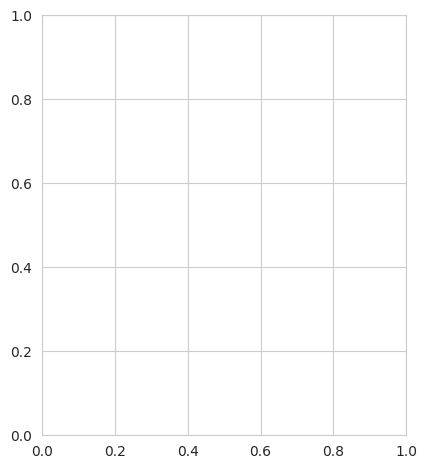

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get test data
test_data = next(iter(test_dataloader))
test_data = test_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    probs = torch.sigmoid(logits).squeeze()
    predictions = (probs >= 0.5).float()
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
probs_flat = probs.cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=2)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=2)
x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Up (1)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_flat[actuals_flat == 0], bins=30, alpha=0.6, label='Actual Down', color='red', edgecolor='black')
ax3.hist(probs_flat[actuals_flat == 1], bins=30, alpha=0.6, label='Actual Up', color='green', edgecolor='black')
ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by prediction correctness
correct_mask = (preds_flat == actuals_flat)
ax4.scatter(returns_flat[correct_mask], probs_flat[correct_mask], 
           alpha=0.5, label='Correct', color='green', s=10)
ax4.scatter(returns_flat[~correct_mask], probs_flat[~correct_mask], 
           alpha=0.5, label='Incorrect', color='red', s=10)
ax4.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (50%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Up (1)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Up (1):
  Precision: {report['Up (1)']['precision']:.3f}
  Recall: {report['Up (1)']['recall']:.3f}
  F1-Score: {report['Up (1)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"Predicted Up: {preds_flat.sum():.0f} ({preds_flat.mean():.2%})")
print(f"Actual Up: {actuals_flat.sum():.0f} ({actuals_flat.mean():.2%})")
print(f"Average prediction probability: {probs_flat.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"{'='*60}\n")


## Hybrid graph prediction

In [13]:
# Load the saved model - HYBRID THRESHOLD model
device = torch.device('cuda')

# IMPORTANT: Use the EXACT same configuration as when the model was trained
# The hybrid_threshold model was trained with:
# - 3 classes (Down, Neutral, Up)
# - use_gat=True (as shown in training cell)
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 3, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=True)  # Match training config

# Load the saved state dict
model_path = f"models/saved_models/UpDownTrend_hybrid_threshold_{model.__class__.__name__}.pt"
try:
    model.load_state_dict(torch.load(model_path))
    print(f"✓ Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"✗ Model file not found at {model_path}")
    print(f"  Available models:")
    import os
    for f in os.listdir("models/saved_models/"):
        if "TGCN" in f:
            print(f"    - {f}")

model = model.to(device)
model.eval()

print(f"Model architecture: {model.__class__.__name__}")
print(f"Parameters: in_channels={in_channels}, out_channels={out_channels}, hidden_size={hidden_size}, layers_nb={layers_nb}, use_gat=True")
print(f"Device: {device}")

✓ Model loaded successfully from models/saved_models/UpDownTrend_hybrid_threshold_TGCN.pt
Model architecture: TGCN
Parameters: in_channels=13, out_channels=3, hidden_size=16, layers_nb=2, use_gat=True
Device: cuda


ValueError: Found input variables with inconsistent numbers of samples: [6800, 20400]

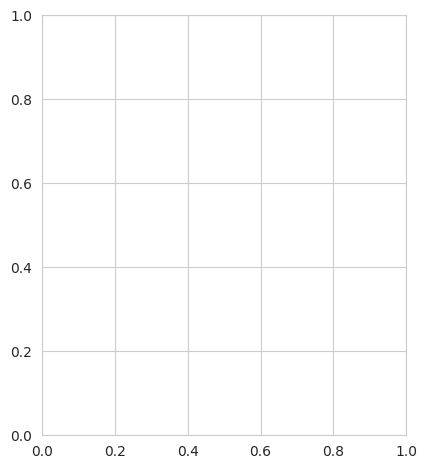

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get test data
test_data = next(iter(test_dataloader))
test_data = test_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    probs = torch.sigmoid(logits).squeeze()
    predictions = (probs >= 0.5).float()
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
probs_flat = probs.cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=2)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=2)
x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Up (1)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_flat[actuals_flat == 0], bins=30, alpha=0.6, label='Actual Down', color='red', edgecolor='black')
ax3.hist(probs_flat[actuals_flat == 1], bins=30, alpha=0.6, label='Actual Up', color='green', edgecolor='black')
ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by prediction correctness
correct_mask = (preds_flat == actuals_flat)
ax4.scatter(returns_flat[correct_mask], probs_flat[correct_mask], 
           alpha=0.5, label='Correct', color='green', s=10)
ax4.scatter(returns_flat[~correct_mask], probs_flat[~correct_mask], 
           alpha=0.5, label='Incorrect', color='red', s=10)
ax4.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (50%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Up (1)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Up (1):
  Precision: {report['Up (1)']['precision']:.3f}
  Recall: {report['Up (1)']['recall']:.3f}
  F1-Score: {report['Up (1)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"Predicted Up: {preds_flat.sum():.0f} ({preds_flat.mean():.2%})")
print(f"Actual Up: {actuals_flat.sum():.0f} ({actuals_flat.mean():.2%})")
print(f"Average prediction probability: {probs_flat.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"{'='*60}\n")


As we can appreciate, the results obtained on both graph roughly surpass 50% of accuracy (almost as good as flipping a coin). This suggest that the current experiment design could be inpractical. A likely explanation is that the model is exposed to a lot of noise. An increase of 0.001% will be categorized upward as well as an increase of 1%. Therefor a fundamental improvement could be adding a new prediction label "neutral" that label those insignificant variations as a new category and then handle better that noise.

## Neutral label

In [15]:

# Load the saved model
device = torch.device('cuda')
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 3, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

# Load the saved state dict
model_path = f"models/saved_models/UpDownTrend_hybrid_threshold_{model.__class__.__name__}.pt"
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

print(f"Model loaded successfully from {model_path}")
print(f"Model architecture: {model.__class__.__name__}")
print(f"Parameters: in_channels={in_channels}, out_channels={out_channels}, hidden_size={hidden_size}, layers_nb={layers_nb}")
print(f"Device: {device}")


Model loaded successfully from models/saved_models/UpDownTrend_hybrid_threshold_TGCN.pt
Model architecture: TGCN
Parameters: in_channels=13, out_channels=3, hidden_size=16, layers_nb=2
Device: cuda


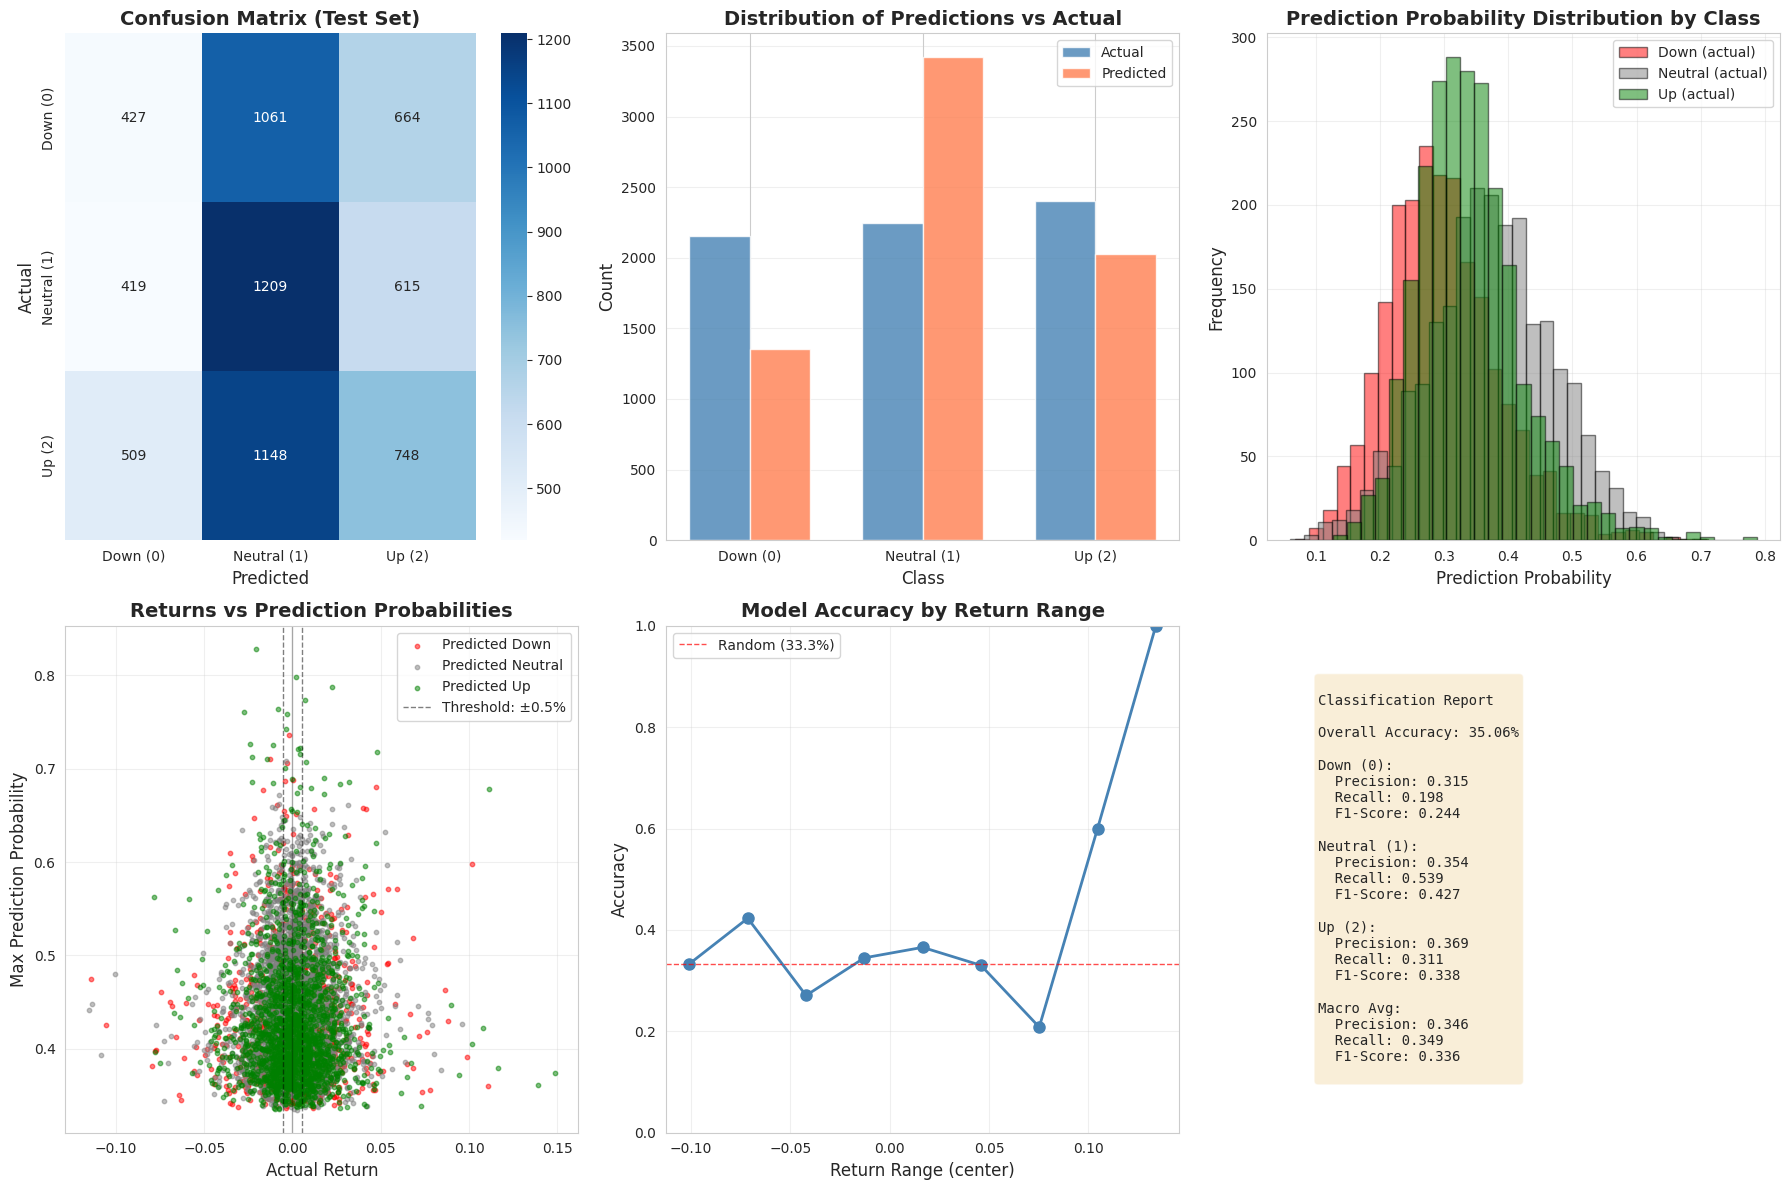


PREDICTION VISUALIZATION SUMMARY
Total predictions: 6800
Overall accuracy: 35.06%

Class Distribution (Actual):
  Down (0):    2152 (31.65%)
  Neutral (1):  2243 (32.99%)
  Up (2):      2405 (35.37%)

Class Distribution (Predicted):
  Down (0):    1355 (19.93%)
  Neutral (1):  3418 (50.26%)
  Up (2):      2027 (29.81%)

Average max prediction probability: 0.435
Average actual return: 0.0008 (0.08%)
Threshold used: ±0.55%



In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Get test data
test_data = next(iter(test_dataloader))
test_data = test_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    # Use softmax for multi-class classification (3 classes)
    probs = F.softmax(logits, dim=-1)  # Shape: (nodes, 3)
    predictions = probs.argmax(dim=-1)  # Get predicted class (0, 1, or 2)
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
# Get max probability for each prediction
probs_max = probs.max(dim=-1)[0].cpu().numpy().flatten()
# Get probabilities for each class
probs_down = probs[:, 0].cpu().numpy().flatten()
probs_neutral = probs[:, 1].cpu().numpy().flatten()
probs_up = probs[:, 2].cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat, labels=[0, 1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Neutral (1)', 'Up (2)'], 
            yticklabels=['Down (0)', 'Neutral (1)', 'Up (2)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=3)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=3)
x = np.arange(3)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Neutral (1)', 'Up (2)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution by Class
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_down[actuals_flat == 0], bins=30, alpha=0.5, label='Down (actual)', color='red', edgecolor='black')
ax3.hist(probs_neutral[actuals_flat == 1], bins=30, alpha=0.5, label='Neutral (actual)', color='gray', edgecolor='black')
ax3.hist(probs_up[actuals_flat == 2], bins=30, alpha=0.5, label='Up (actual)', color='green', edgecolor='black')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions (colored by class)
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by predicted class
for class_idx, color, label in [(0, 'red', 'Predicted Down'), (1, 'gray', 'Predicted Neutral'), (2, 'green', 'Predicted Up')]:
    mask = (preds_flat == class_idx)
    if mask.sum() > 0:
        ax4.scatter(returns_flat[mask], probs_max[mask], 
                   alpha=0.5, label=label, color=color, s=10)
ax4.axvline(x=-threshold, color='black', linestyle='--', linewidth=1, alpha=0.5, label=f'Threshold: ±{threshold*100:.1f}%')
ax4.axvline(x=threshold, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Max Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=1/3, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (33.3%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Neutral (1)', 'Up (2)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Neutral (1):
  Precision: {report['Neutral (1)']['precision']:.3f}
  Recall: {report['Neutral (1)']['recall']:.3f}
  F1-Score: {report['Neutral (1)']['f1-score']:.3f}

Up (2):
  Precision: {report['Up (2)']['precision']:.3f}
  Recall: {report['Up (2)']['recall']:.3f}
  F1-Score: {report['Up (2)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"\nClass Distribution (Actual):")
print(f"  Down (0):   {np.sum(actuals_flat == 0):5d} ({np.mean(actuals_flat == 0)*100:5.2f}%)")
print(f"  Neutral (1): {np.sum(actuals_flat == 1):5d} ({np.mean(actuals_flat == 1)*100:5.2f}%)")
print(f"  Up (2):     {np.sum(actuals_flat == 2):5d} ({np.mean(actuals_flat == 2)*100:5.2f}%)")
print(f"\nClass Distribution (Predicted):")
print(f"  Down (0):   {np.sum(preds_flat == 0):5d} ({np.mean(preds_flat == 0)*100:5.2f}%)")
print(f"  Neutral (1): {np.sum(preds_flat == 1):5d} ({np.mean(preds_flat == 1)*100:5.2f}%)")
print(f"  Up (2):     {np.sum(preds_flat == 2):5d} ({np.mean(preds_flat == 2)*100:5.2f}%)")
print(f"\nAverage max prediction probability: {probs_max.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"Threshold used: ±{threshold*100:.2f}%")
print(f"{'='*60}\n")


## Threshold Analysis: Choosing Between 3-Class vs 2-Class

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Analyze the current dataset to understand threshold impact
print("="*70)
print("THRESHOLD ANALYSIS: 3-CLASS vs 2-CLASS")
print("="*70)

# Get all returns from dataset
all_returns = []
for i in range(len(dataset)):
    sample_returns = dataset[i].returns.squeeze().cpu().numpy()
    all_returns.extend(sample_returns)

all_returns = np.array(all_returns)

# Test different thresholds
thresholds = [0.005, 0.01, 0.015, 0.02, 0.03]

results = []
for thresh in thresholds:
    # 3-class distribution
    down_3class = np.sum(all_returns < -thresh)
    neutral_3class = np.sum((all_returns >= -thresh) & (all_returns <= thresh))
    up_3class = np.sum(all_returns > thresh)
    total_3class = down_3class + neutral_3class + up_3class
    
    # 2-class distribution (excluding neutral)
    down_2class = down_3class
    up_2class = up_3class
    excluded = neutral_3class
    total_2class = down_2class + up_2class
    
    results.append({
        'threshold': thresh,
        'down_3class': down_3class / total_3class * 100,
        'neutral_3class': neutral_3class / total_3class * 100,
        'up_3class': up_3class / total_3class * 100,
        'down_2class': down_2class / total_2class * 100 if total_2class > 0 else 0,
        'up_2class': up_2class / total_2class * 100 if total_2class > 0 else 0,
        'data_kept': total_2class / total_3class * 100,
        'data_excluded': excluded,
        'total_samples': total_3class
    })

# Print comparison table
print(f"\n{'Threshold':<12} {'Down':<8} {'Neutral':<10} {'Up':<8} {'Data Kept':<12} {'Excluded':<10}")
print(f"{'(±%)':<12} {'(3-cls)':<8} {'(3-cls)':<10} {'(3-cls)':<8} {'(2-cls)':<12} {'(samples)':<10}")
print("-" * 80)

for r in results:
    print(f"±{r['threshold']*100:.2f}%     {r['down_3class']:>6.1f}%  {r['neutral_3class']:>8.1f}%  {r['up_3class']:>6.1f}%  {r['data_kept']:>10.1f}%  {r['data_excluded']:>8.0f}")

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)

# Find balanced threshold
best_idx = np.argmin([abs(r['down_2class'] - r['up_2class']) for r in results])
best = results[best_idx]

print(f"\n✓ Most Balanced 2-Class (±{best['threshold']*100:.2f}%):")
print(f"  - Down class: {best['down_2class']:.1f}% ({int(best['down_3class']):.0f} samples)")
print(f"  - Up class:   {best['up_2class']:.1f}% ({int(best['up_2class'] * best['total_samples'] / 100):.0f} samples)")
print(f"  - Data retained: {best['data_kept']:.1f}%")
print(f"  - Random baseline: 50%")
print(f"  - Target accuracy: >55-60%")

print(f"\n✓ Current 3-Class (±{threshold*100:.2f}%):")
print(f"  - Down class:    {results[0]['down_3class']:.1f}%")
print(f"  - Neutral class: {results[0]['neutral_3class']:.1f}%")
print(f"  - Up class:      {results[0]['up_3class']:.1f}%")
print(f"  - Random baseline: 33.3%")
print(f"  - Target accuracy: >40-45%")

print("\n" + "="*70)
print("SUMMARY:")
print("="*70)
print(f"""
The data shows that with a ±{threshold*100:.2f}% threshold:
- Your NEUTRAL zone captures {results[0]['neutral_3class']:.1f}% of data
- This is too much noise for the model to distinguish up vs down
- Reducing to 2-class would exclude {results[0]['data_excluded']:.0f} ambiguous samples
- This leaves a CLEANER signal with ~{best['data_kept']:.0f}% of data

RECOMMENDED NEXT STEP:
→ Retrain with 2-class (Up/Down) using ±{best['threshold']*100:.2f}% threshold
→ If 2-class reaches >60% accuracy, you can then:
  - Add back neutral class with better regularization
  - Or use current 2-class model for trading
""")


THRESHOLD ANALYSIS: 3-CLASS vs 2-CLASS

Threshold    Down     Neutral    Up       Data Kept    Excluded  
(±%)         (3-cls)  (3-cls)    (3-cls)  (2-cls)      (samples) 
--------------------------------------------------------------------------------
±0.50%       31.3%      32.1%    36.6%        67.9%     21724
±1.00%       19.6%      57.0%    23.4%        43.0%     38581
±1.50%       12.1%      73.6%    14.3%        26.4%     49831
±2.00%        7.6%      83.6%     8.7%        16.4%     56610
±3.00%        3.3%      93.0%     3.7%         7.0%     62982

RECOMMENDATIONS:

✓ Most Balanced 2-Class (±3.00%):
  - Down class: 47.5% (3 samples)
  - Up class:   52.5% (35528 samples)
  - Data retained: 7.0%
  - Random baseline: 50%
  - Target accuracy: >55-60%

✓ Current 3-Class (±0.55%):
  - Down class:    31.3%
  - Neutral class: 32.1%
  - Up class:      36.6%
  - Random baseline: 33.3%
  - Target accuracy: >40-45%

SUMMARY:

The data shows that with a ±0.55% threshold:
- Your NEUTRAL zon